# Lab 4 - Logistic Regression (corrected the title from *Lab 5* into *Lab 4*)

In this lab we implement and use logistic regressione for binary claffication problems.

We start including some libraries and functions already seen in the previous labs (or slight variations of them). Have a look and verify you understand their purpose.

<b>READ all the text parts very carefully, as you will find instructions on how to proceed.</b>

In [1]:
#Matteo Pastorino Ghezzi
#Riccardo Caprile
#Andrea Valli
#Filippo Montanaro

In [2]:
# import libraries
%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.interpolate import griddata
import math

In [3]:
def mixGauss(means, sigmas, n):
    """
    means : 2D array (num_classes, d)
        Each row of the array gives the mean of the Gaussian in multiple dimensions for one class.
        For binary classification problems, the number of rows should be 2!
    sigmas : 1D array (num_classes)
        The standard deviation for the Gaussian distribution of each class (isotropic Gaussian!)
    
    Example:
    
    >>> means = [[3, 0], [0, 0]]
    >>> sigmas = [0.5, 1]
    >>> X, Y = mixGauss(means, sigmas, n=100)
    >>> fig, ax = plt.subplots()
    >>> ax.scatter(X[Y == 1,0], X[Y == 1,1], marker='o', color='r')
    >>> ax.scatter(X[Y == -1,0], X[Y == -1,1], marker='o', color='b')
    """
    means = np.array(means)
    sigmas = np.array(sigmas)

    d = means.shape[1]
    num_classes = sigmas.size
    data = np.full((n * num_classes, d), np.inf)
    labels = np.zeros(n * num_classes)

    for idx, sigma in enumerate(sigmas):
        data[idx * n:(idx + 1) * n] = np.random.multivariate_normal(
            mean=means[idx], cov=np.eye(d) * sigmas[idx] ** 2, size=n)
        labels[idx * n:(idx + 1) * n] = idx 
        
    if(num_classes == 2):
        labels[labels==0] = -1

    return data, labels

In [4]:
def flipLabels(Y, perc):
    if perc < 1 or perc > 100:
        print("p should be a percentage value between 0 and 100.")
        return -1

    if any(np.abs(Y) != 1):
        print("The values of Ytr should be +1 or -1.")
        return -1

    Y_noisy = np.copy(np.squeeze(Y))
    if Y_noisy.ndim > 1:
        print("Please supply a label array with only one dimension")
        return -1

    n = Y_noisy.size
    n_flips = int(np.floor(n * perc / 100))
    idx_to_flip = np.random.choice(n, size=n_flips, replace=False)
    Y_noisy[idx_to_flip] = -Y_noisy[idx_to_flip]

    return Y_noisy

In [5]:
def separatingFLR(Xtr, Ytr, Ypred, w):
    fig, ax = plt.subplots()
    xi = np.linspace(Xtr[:, 0].min(), Xtr[:, 0].max(), 200)
    yi = np.linspace(Xtr[:, 1].min(), Xtr[:, 1].max(), 200)
    X, Y = np.meshgrid(xi,yi)
    
    zi = griddata(Xtr, Ypred, (X,Y), method='linear')
    
    ax.contour(xi, yi, zi, 15, linewidths=2, colors='k', levels=[0])
    # plot data points.
    ax.scatter(Xtr[:,0], Xtr[:,1], c=Ytr, marker='o', s=100, zorder=10, alpha=0.8)
    ax.set_xlim(Xtr[:,0].min(), Xtr[:,0].max())
    ax.set_ylim(Xtr[:,1].min(), Xtr[:,1].max())

## Linear logistic regression with gradient descent

We define two functions:
 - the `optimal_gd_learning_rate(Xtr, reg_par)` function calculates the optimal learning rate for GD on a given dataset. You will need to use the SVD of the covariance matrix.
 - the `train_logreg_gd(Xtr, Ytr, reg_par, maxiter)` function estimates the classifier weights on the training set.

<br>

The parameters of the `optimal_gd_learning_rate` function are:
- <b>Xtr</b> is the nxD matrix of training set inputs
- <b>reg_par</b> is the value of the lambda

and it should output the learning rate $\gamma$ (a scalar).
You should use the `np.linalg.eigvalsh` function to calculate the eigenvalues of the covariance matrix.

<br>

The parameters of the `train_logreg_gd` function are:
- <b>Xtr</b> is the nxD matrix of training set inputs
- <b>Ytr</b> is the n vector of training set outputs
- <b>reg_par</b> is the value of the lambda
- <b>maxiter</b> is the maximum number of iterations to run gradient descent

and it should output:
- <b>w</b> is the D vector of the estimated function parameters
- <b>losses</b> is the vector of the loss at each iteration


In [6]:
def optimal_gd_learning_rate(Xtr, reg_par):
    # Estimate the gamma parameter: the optimal learning rate for gradient descent
    A = np.dot(Xtr, np.transpose(Xtr))   # code correction seen in class 
    n = np.shape(Xtr)
    eigvals = np.linalg.eigvalsh(A)
    max_eig = np.max(eigvals)
    L = (max_eig / n) + 2 * reg_par
    gamma = 1 / L
    return gamma[0]  # returning a vector?? should be a scalar --> fixed (?)

In [7]:
def train_logreg_gd(Xtr, Ytr, reg_par, maxiter=100):
    """
    Xtr : array of shape n, d
    Ytr : array of shape n, or of shape n, 1
    reg_par : regularization parameter (a scalar)
    maxiter : the maximum number of gradient-descent iterations
    """
    # Epsilon is a criterion for early stopping
    epsilon = 1e-6
    
    # size of the input in the training
    n, D = np.shape(Xtr)
    #print("Ytr shape is: " + str(Ytr.shape))
    
    # initialization of the vector w
    w = np.zeros((D, 1))
    
    # Set the learning rate optimally
    gamma = optimal_gd_learning_rate(Xtr, reg_par)

    # initialization of some supporting variables
    j = 0
    loss_old = 0
    loss = float("inf")
    training_losses = np.zeros(maxiter + 1)
    #print(training_losses)
    #Ytr = Ytr.reshape(-1, 1)  # Convert from shape n, to shape n, 1 ---> by commenting this, the shape are coeherent
    while j < maxiter and abs(loss - loss_old) >= epsilon:
        lossold = loss
        j = j + 1

        # w code
        p = np.exp(np.dot(-Ytr,np.dot(Xtr,w)))
        fact = p/(1+p)  # had to do this: in classe we saw the simplification but I get something wrong here 
        w= w - gamma * (-(1/n)* fact * np.dot(np.transpose(Xtr),Ytr)+ 2 * reg_par * w)

        # loss code
        A1 = np.dot(Xtr, w)
        A2 = np.exp(np.dot(Ytr, A1))
        loss = min((np.log(1 + A2) / n) + reg_par * np.linalg.norm(w)**2)
        training_losses[j] = abs(loss-lossold)
        #print("Loss at iteration " + str(j) + " is: " + str(training_losses[j]))

    return w, training_losses[0:j]

### Evaluation the function on the test set

A function to perform predictions on a set of samples given the learned logistic regression weights

##### Ypred, Ppred = predict_logreg(weights, Xte)
where
- <b>weights</b> is the D vector of the estimated function parameters
- <b>X</b> is the matrix of input points of the training or test set.
- <b>Ypred</b> is the vector of predictions
- <b>Ppred</b> is the predicted probability of a point belonging to class +1. It will be 0 if the model is very confident the point belongs to class -1, it will be 1 if the model is very confident that the point belongs to class +1.

In [8]:
def predict_logreg(weights, X):
    """
    weights : array of shape d, 1
    X : array of shape n, d
    """
    ypred = np.dot(X, weights)
    # Try and understand what it does, deriving the formula
    ppred = 1 / (1 + np.exp(-ypred))  # confidence formula
    # The outputs are reshaped to be 1D vectors.
    return ypred.reshape(-1), ppred.reshape(-1)

In [9]:
def calcError(Ypred, Y):
    class_err = np.mean(np.sign(Ypred) != Y)
    return class_err

## Initial Analysis

Perform the following tasks for the initial analysis:

1. Create two binary classification datasets (training and test sets) -- Use the same parameters. Visualize them in a scatter plot.

2. Pick a reasonable value for lambda (e.g. reg_par = 0.1, 0.01, 0.001, ...) and train a logistic-regression model using the functions you have defined.

3. Plot the loss at each iteration which is returned by the training function. The loss should decrease at each iteration, **if the loss does not decrease there is an error in the implementation!**

4. Use the `separatingFLR` function to plot the separating curve obtained with the model

5. Evaluate the error training and test sets.

**Important #1**: The parameters used to generate the data are quite important. Try to make sure that the two classes are distinct (i.e. the means of the Gaussians should be different), but also not too far. Ideally a few points should overlap between the classes.
Make sure to generate at least 100 points for both train and test sets.

**Important #2**: since we are implementing a linear model, we must add a bias term -- otherwise the weights will draw a line which always goes through 0. An alternative to adding a bias term to the model is to add a feature comprising all ones to the data-column. We can use the following code for this:
```
Xtr_wbias = np.hstack((Xtr, np.ones((Xtr.shape[0], 1))))
Xts_wbias = np.hstack((Xts, np.ones((Xts.shape[0], 1))))
```
what will be the resulting shape of the weight vector `w`?

<Figure size 432x288 with 0 Axes>

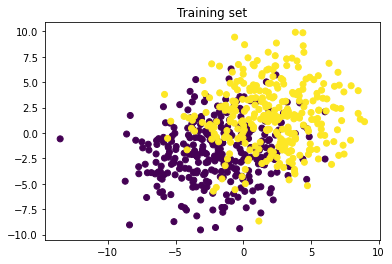

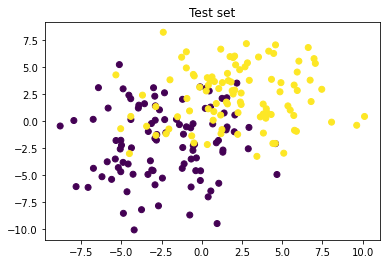

<Figure size 432x288 with 0 Axes>

In [10]:
# Help for data-generation
means = [[-2, -2], [2, 2]]
sigmas = [3, 3]

Xtr, Ytr = mixGauss(means, sigmas, 300)
Xts, Yts = mixGauss(means, sigmas, 100)

Xtr_wbias = np.hstack((Xtr, np.ones((Xtr.shape[0], 1))))
Xts_wbias = np.hstack((Xts, np.ones((Xts.shape[0], 1))))

# TODO: Plot training and test sets, coloring the two classes differently.

#plotting the training set
plt.scatter(Xtr[:, 0], Xtr[:, 1], c=Ytr)
plt.title("Training set")
plt.figure()

#plotting the test set
plt.scatter(Xts[:, 0], Xts[:, 1], c=Yts)
plt.title("Test set")
plt.figure()

Text(0.5, 1.0, 'Loss at each iteration')

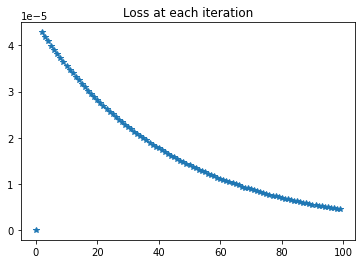

In [11]:
reg_par = 0.1
estw, losses = train_logreg_gd(Xtr_wbias, Ytr, reg_par, 100)  # Careful: use the datasets with the bias.
w = estw[1,:] # taking the first row only (the other two were identical)
# TODO: Plot the losses
plt.plot(losses,'--*')
plt.title("Loss at each iteration")

Text(0.5, 1.0, 'Separating curve on the test set')

<Figure size 432x288 with 0 Axes>

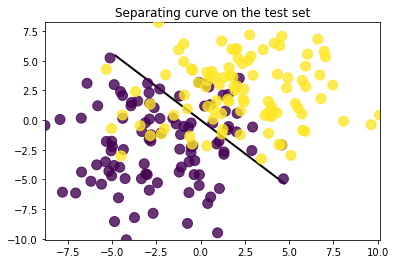

In [12]:
# TODO: Plot the separating curve (on the test set)
Ypred, Ppred = predict_logreg(w, Xts_wbias)
plt.figure()
separatingFLR(Xts,Yts,Ypred,estw) # AttributeError: 'AxesSubplot' object has no attribute 'xlim' --> should we change the given function??
                                  # I change the given function with 'set_xlim' and 'set_ylim' 
plt.title("Separating curve on the test set")

In [13]:
# TODO: Evaluate the errors
tr_pred, _ = predict_logreg(w,Xtr_wbias)
tr_err = calcError(tr_pred,Ytr)
ts_pred, _ = predict_logreg(w,Xts_wbias)
ts_err = calcError(ts_pred,Yts)
print("Training error: %.2f%%, Test error: %.2f%%" % (tr_err * 100, ts_err * 100))

Training error: 18.83%, Test error: 17.00%


## Interpreting the confidence of logistic regression predictions

Logistic regression does not only output *pointwise predictions* (the class to which a point belongs), but it also gives the **probability** that a test point belongs to a certain class.

This probability can be very useful to interpret the outputs of your model: in certain cases it might be better to **not predict anything** if the confidence of the model is low (i.e. if the model predicts a probability of 0.5 in a binary setting, the model is not sure which class a point belongs to).

In this part of the lab, we will
 1. Implement a function which allows to visualize the confidence of predictions (`plot_logreg_confidence`)
 2. Train a logistic regression model, and use the visualization function to see where the low confidence region of prediction lies.
 3. Calculate the error on **just the high-confidence** predictions, and see how the it changes.

In [14]:
def plot_logreg_confidence(X, Y, pred_confidence, threshold):
    """
    X : a (n, d) dataset
    Y : a (n, ) array of targets
    pred_confidence : A (n, ) array of probabilities predicted from X
    threshold : a float between 0 and 0.5 determining the probability threshold we use to 
                consider neutral predictions. For example if threshold=0.1 then all probabilities
                between 0.4 and 0.6 will be considered neutral (that is, neither belonging to class +1
                or to class -1).
    """
    fig, ax = plt.subplots()
    xi = np.linspace(X[:, 0].min(), X[:, 0].max(), 200)
    yi = np.linspace(X[:, 1].min(), X[:, 1].max(), 200)
    X_grid, Y_grid = np.meshgrid(xi,yi)
    
    zi = griddata(X, pred_confidence, (X_grid, Y_grid), method='linear')
    
    ax.contour(xi, yi, zi, 15, linewidths=2, levels=[0.5 - threshold, 0.5 + threshold])
    
    # Plot data points
    ax.scatter(X[:,0], X[:,1], c=Y, 
               marker='o', s=100, zorder=10, alpha=0.8)
    ax.set_xlim(X[:,0].min(), X[:,0].max())
    ax.set_ylim(X[:,1].min(), X[:,1].max())

In [15]:
# Generate some data
Xtr, Ytr = mixGauss([[0,1],[1,1]], [0.4,0.4], 100)
Xts, Yts = mixGauss([[0,1],[1,1]], [0.4,0.4], 100)

Xtr_wbias = np.hstack((Xtr, np.ones((Xtr.shape[0], 1))))
Xts_wbias = np.hstack((Xts, np.ones((Xts.shape[0], 1))))  # corrected from Xte to Xts

<ipython-input-14-98e5cdbf22f4>:18: UserWarning: No contour levels were found within the data range.
  ax.contour(xi, yi, zi, 15, linewidths=2, levels=[0.5 - threshold, 0.5 + threshold])


<Figure size 432x288 with 0 Axes>

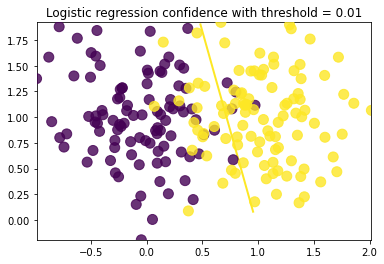

<Figure size 432x288 with 0 Axes>

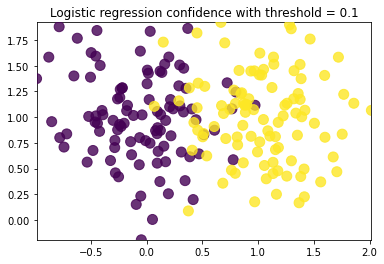

<Figure size 432x288 with 0 Axes>

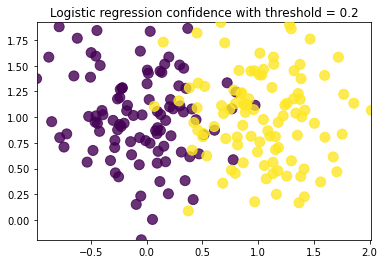

<Figure size 432x288 with 0 Axes>

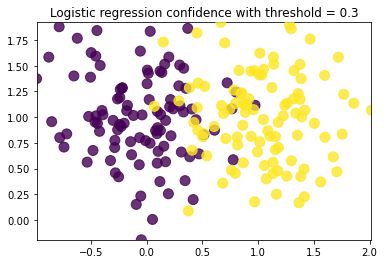

<Figure size 432x288 with 0 Axes>

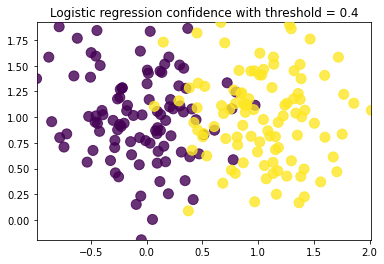

<Figure size 432x288 with 0 Axes>

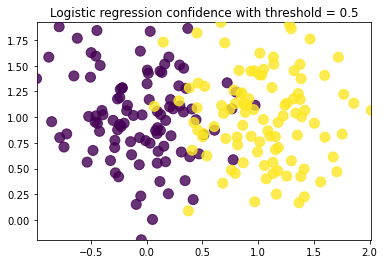

In [16]:
# TODO: Train a logistic regression model, and obtain the probability predictions for the test set
reg_par = 0.1  # value changed out of curiosity
estw, losses = train_logreg_gd(Xtr_wbias, Ytr, reg_par, 100)
w = estw[1,:]
ts_pred, ts_conf = predict_logreg(w,Xts_wbias)

# TODO: Plot the logistic regression confidence for different thresholds. Interpret what you see.
thr = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5] # value 0 gives error
for i in range(len(thr)):
  plt.figure()
  plot_logreg_confidence(Xts, Yts, ts_conf,thr[i])
  plt.title("Logistic regression confidence with threshold = " +str(thr[i]))

### ***Interpret what you see:*** with thr > 0.01, the confidence line disappear (?)

In [17]:
def calc_error_with_confidence(prob_pred, Y, threshold):
    """
    Calculate the classification error on only the predictions with a high confidence!
    """
    class_m1 = prob_pred <= 0.5 - threshold
    class_p1 = prob_pred > 0.5 + threshold
    
    err_class_m1 = Y[class_m1] != -1
    err_class_p1 = Y[class_p1] != 1
    return (np.sum(err_class_m1) + np.sum(err_class_p1)) / (len(err_class_m1) + len(err_class_p1))

In [18]:
# TODO: Train a log-reg model, and calculate the error on only the high-confidence examples from the test
#       set. How do you expect this error to behave as you change the threshold?

reg_par = 0.001 # getting significant error values with this reg_par
estw, losses = train_logreg_gd(Xtr_wbias, Ytr, reg_par, 100)
w = estw[1,:]
ts_pred, ts_conf = predict_logreg(w,Xts_wbias)
thr = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5] # value 0 gives error
for i in range(len(thr)):
  err_high_conf = calc_error_with_confidence(ts_pred,Yts,thr[i])
  print('%.5f' %err_high_conf)

# by increasing the threshold, the error goes to 0

0.50000
0.50000
0.50000
0.48980
0.17241
0.00000


## Logistic Regression with Stochastic Gradient Descent

SGD is quite similar to GD, but instead of updating the weights with the gradient of all the training samples at once, at each step it updates the weights with the **gradient of a single sample** picked at random from the training set.

Since at each iteration it uses a single sample it will be much faster, but it will need more iterations.

In this last part you will:
 1. Implement a SGD solver for logistic regression
 2. Use it to learn a logistic-regression model
 3. Compare the results to learning with GD.

In [19]:
def train_logreg_sgd(Xtr, Ytr, reg_par, maxiter=100):
    """
    Xtr : array of shape n, d
    Ytr : array of shape n, or of shape n, 1
    reg_par : regularization parameter (a scalar)
    maxiter : the maximum number of gradient-descent iterations
    """
    epsilon = 1e-6
    # size of the input in the training
    n, D = np.shape(Xtr)
    # initialization of the vector w
    w = np.zeros(D)
    
    # initialization of some supporting variables
    training_losses = np.zeros(maxiter + 1)
    loss_sum = 0
    #Ytr = Ytr.reshape(-1, 1)  # Convert from shape n, to shape n, 1
    for j in range(maxiter):
        # The learning rate here is different from GD. You can take
        # a) 1 / sqrt(n)
        # b) 1 / sqrt(j) : the learning rate decreases at each iteration.
        # Which one do you expect leads to faster convergence? The one I picked below
        gamma = 1 / math.sqrt(n)

        # TODO: Choose the sample current stample from Xtr **at random**
        sample_idx = np.random.randint(0, n)
        # TODO: Use the formulas from the slides to update the weight vector
        
        p = np.exp(np.dot(Ytr[sample_idx],np.dot(Xtr[sample_idx].T,w)))
        fact = p/(1+p)  # had to do this: in classe we saw the simplification but I get something wrong here 
        w = w - gamma * (-(1/n)* np.dot(fact.T, np.dot(Ytr[sample_idx],Xtr[sample_idx])) + 2 * reg_par * w)

        # TODO: Calculate the loss on the current sample.
        loss_sum = 0       
        for i in range(n):
          sum_loss = np.log(1+np.exp(-Ytr[sample_idx]*np.dot(w.T, Xtr[sample_idx])))
        loss = 1/n*sum_loss+reg_par*(np.linalg.norm(w,2)**2)

        training_losses[j] = loss
        print("Loss at iteration " + str(j) + " is: " + str(training_losses[j])) 
        if j > 0 and abs(training_losses[j] - training_losses[j-1]) < epsilon:
            break   
    return w, training_losses[:j]

In [20]:
# TODO: Generate a dataset (use the code from the previous parts)
Xtr, Ytr = mixGauss([[0,0],[1,1]], [0.25,0.25], 200)
Xts, Yts = mixGauss([[0,0],[1,1]], [0.25,0.25], 200)

Xtr_wbias = np.hstack((Xtr, np.ones((Xtr.shape[0], 1))))
Xts_wbias = np.hstack((Xts, np.ones((Xts.shape[0], 1))))

In [21]:
# TODO: Train logistic regression with SGD
w_sgd,losses_sgd = train_logreg_sgd(Xtr_wbias, Ytr, reg_par, 100)
# TODO: Train logistic regression with GD
w_gd,losses_gd = train_logreg_gd(Xtr_wbias, Ytr, reg_par, 100)

Loss at iteration 0 is: 0.0017326687843900988
Loss at iteration 1 is: 0.0017328279688024958


In [22]:
# TODO: Compare the two in terms of:
#  1. number of iterations needed to converge (keep in mind that GD iterations cost n times more)
#  2. accuracy.

# **1.**
SGD is way faster than GD as the computational effort is bigger in GD

# **2.**
The problem with SDG is that it's less accurate than GD: in SGD, the sample is selected randomly and so it's only able to get close to the global minimum  
